# 8-bit music reconstruction with GA

Giovanni Zanin 
IN2000192

### Imports:
- numpy for dealing with array and signals
- math for the calculation of the frequencies of the notes
- matplotlib.pyplot for representing the results
- wave to read and create .wav files
- interp1d to interpolate signals
- fft to compute the Fourier transform of signals
- pywt to compute the Wavelet transform of signals

In [5]:
%pip install scipy
import numpy as np
import math
import matplotlib.pyplot as plt
import wave
from scipy.interpolate import interp1d
from scipy.fft import fft
import pywt

Note: you may need to restart the kernel to use updated packages.


### Some useful methods

In [6]:

def generate_random_signal(duration, sample_rate):
    num_samples = int(duration * sample_rate)
    random_signal = np.random.randint(0, 256, size=num_samples, dtype=np.uint8)
    return random_signal

def save_wave_file(filename, signal, sample_rate):
    with wave.open(filename, 'w') as wave_file:
        wave_file.setnchannels(1)  # 1 canale (mono)
        wave_file.setsampwidth(1)  # profondità in bit (8 bit)
        wave_file.setframerate(sample_rate)
        wave_file.writeframes(signal.tobytes())

def read_wave_file(filename):
    with wave.open(filename, 'r') as wave_file:
        nframes=wave_file.getnframes()
        nbits= 8*wave_file.getsampwidth()
        dtype_name = f'uint{nbits}'
        dtype = getattr(np, dtype_name)
        signal= np.frombuffer(wave_file.readframes(nframes), dtype=dtype)
    return signal

def plot_signal(signal, title):
    plt.figure(figsize=(10, 4))
    plt.plot(signal, label='Segnale')
    plt.title(title)
    plt.xlabel('Tempo (campioni)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


#### Test

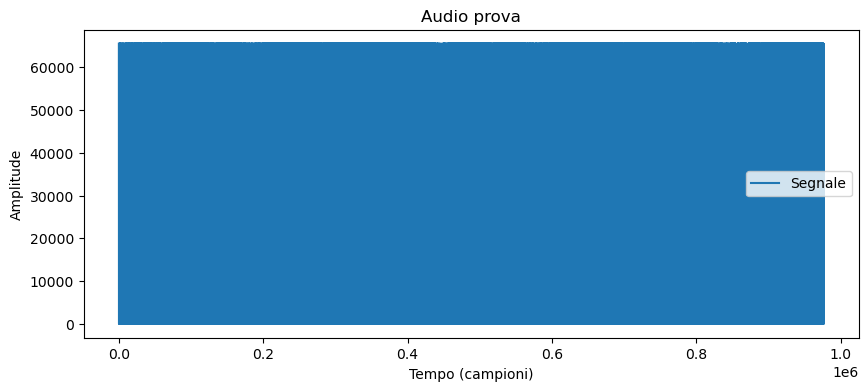

In [7]:
random_signal = generate_random_signal(5, 44100)
save_wave_file('random_signal.wav', random_signal, 44100)

signal1= read_wave_file('caffe.wav')
plot_signal(signal1, 'Audio prova')

### Note

Class to create notes given the duration (in terms of semibisquaver), the intensity (amplitute of the sinusoid), name, octave and starting point (in terms of semibisquaver)

In [8]:
class note:

    NAMES=np.array(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])
    
    def __init__(self, duration_in_64ths, intensity, name, octave, starting_point_in_64ths):
        self.duration_in_64ths= duration_in_64ths

        if (intensity>127):
            self.intensity= 127
        elif (intensity<0):
            self.intensity= 0
        else:
            self.intensity= intensity

        self.name= name
        self.octave= octave
        self.starting_point_in_64ths = starting_point_in_64ths




### Individual

Class to:
- create individuals (candidates), given duration (in seconds), sample rate (in heartz), array of notes and the duration of the semibisquaver in terms of samples
- mutate an individual by changing some (in avarage one) of its notes, but maintaining their durations and starting points (only intensity, name and octave are changed)
- mutate an individual by splitting some (in avarage one) of its notes into two shorter random notes occupying the same position in time space
- mutate an individual by merging some couples of consecutive notes into one longer note occupying the same position in time space
- generate two new individuals through two points crossover (the two points of the crossover are chosen as the starting points of two randomly chosen notes of the first parent, this means tha some notes of the second parent may appear splitted in the offsprings)


 

In [9]:
class individual:
    def __init__(self, duration, sample_rate, notes, duration_of_64ths_in_samples):
        self.__notes = notes
        self.__duration= duration
        self.__sample_rate= sample_rate
        self.__duration_of_64th_in_samples= duration_of_64ths_in_samples
        l= self.__duration*self.__sample_rate
        time = np.arange(0, duration, 1/sample_rate, dtype= np.uint8)
        s = np.full_like(time, 128, dtype=np.uint8)

        for n in notes:
            index = np.where(note.NAMES == n.name)[0]        
            f= 27.5*math.pow(2, n.octave)
            f*= math.pow(math.pow(2, 1/12), (index-9))            
            time = np.arange(0, duration, 1/sample_rate)
            note_representation = np.uint8(n.intensity * np.sin(2 * np.pi * f * time)) 
            initial_sample= max(int(n.starting_point_in_64ths * duration_of_64ths_in_samples), 0)
            final_sample = int(min((n.starting_point_in_64ths+ n.duration_in_64ths) * duration_of_64ths_in_samples, l))
            note_representation[0:initial_sample]=0
            note_representation[final_sample:]=0        
            s+=note_representation

        s= np.clip(s, 0, 255)
        self.__signal= s


    def get_signal(self):
        return self.__signal
    
    def get_duration(self):
        return self.__duration
    
    def get_sample_rate(self):
        return self.__sample_rate
    
    def get_notes(self):
        return self.__notes
    
    def get_duration_of_64th_in_samples(self):
        return self.__duration_of_64th_in_samples
    
    
    def single_note_mutation(self):
        list_of_notes= list(self.__notes)
        copy = list_of_notes.copy()
        for i in range (len(list_of_notes)):
            if (np.random.random()<1/len(self.__notes)):
                new_note = note(list_of_notes[i].duration_in_64ths, np.random.randint(0,127), np.random.choice(note.NAMES), np.random.randint(4,6), list_of_notes[i].starting_point_in_64ths)
                copy= copy[:i]+list([new_note])+copy[i+1:]
        return individual(self.__duration, self.__sample_rate, copy, self.__duration_of_64th_in_samples)
    

    
    def split_note_mutation(self):
        list_of_notes= list(self.__notes)
        new_notes_array=[]
        for i in range (len(self.__notes)):
            if (np.random.random()<1/len(self.__notes) and list_of_notes[i].duration_in_64ths>1):
                duration = list_of_notes[i].duration_in_64ths
                d1= np.random.randint(1,duration)
                d2= duration-d1
                n1= note(d1, np.random.randint(0,127), np.random.choice(note.NAMES), np.random.randint(4,6), list_of_notes[i].starting_point_in_64ths)
                n2= note(d2, np.random.randint(0,127), np.random.choice(note.NAMES), np.random.randint(4,6), list_of_notes[i].starting_point_in_64ths+d1)           
                new_notes_array.append(n1)
                new_notes_array.append(n2)
            else:
                n1= note(list_of_notes[i].duration_in_64ths, list_of_notes[i].intensity, list_of_notes[i].name, list_of_notes[i].octave, list_of_notes[i].starting_point_in_64ths)
                new_notes_array.append(n1)
        return individual(self.__duration, self.__sample_rate, new_notes_array, self.__duration_of_64th_in_samples)
    

    def merge_two_notes_mutation(self):
        list_of_notes= list(self.__notes)
        list_of_notes= sorted(list_of_notes, key=lambda x: x.starting_point_in_64ths)
        new_notes_array=[]
        mutation_log=[]
        mutation_log.append(False) 
        for i in range (len(self.__notes)):
            
            if (mutation_log[i]==False):
                r=np.random.random()
                if (r<(1/(max((len(self.__notes)-1),1))) and i<len(self.__notes)-1):
                    mutation_log.append(True)                    
                    duration = list_of_notes[i].duration_in_64ths + list_of_notes[i+1].duration_in_64ths                
                    n1= note(duration, np.random.randint(0,127), np.random.choice(note.NAMES), np.random.randint(4,6), list_of_notes[i].starting_point_in_64ths)                  
                    new_notes_array.append(n1)
                else:
                    n1= note(list_of_notes[i].duration_in_64ths, list_of_notes[i].intensity, list_of_notes[i].name, list_of_notes[i].octave, list_of_notes[i].starting_point_in_64ths)
                    new_notes_array.append(n1)
                    mutation_log.append(False)
                    
            else:
                mutation_log.append(False)
        
        return individual(self.__duration, self.__sample_rate, new_notes_array, self.__duration_of_64th_in_samples)
    


    def two_points_crossover(p1, p2):
        list_of_notes1= list(p1.get_notes())
        list_of_notes1= sorted(list_of_notes1, key=lambda x: x.starting_point_in_64ths)
        list_of_notes2= list(p2.get_notes())
        list_of_notes2= sorted(list_of_notes2, key=lambda x: x.starting_point_in_64ths)
        notes_off1=[]
        notes_off2=[]
        r1 = np.random.randint(len(list_of_notes1))
        r2= np.random.randint(len(list_of_notes1))
        pt1= min(r1,r2)
        pt2= max(r1,r2)
        t1= list_of_notes1[pt1].starting_point_in_64ths
        t2= list_of_notes1[pt2].starting_point_in_64ths
        index_note_to_split1 = 0
        left_duration1=0
        right_duration1=0
        index_note_to_split2 = 0
        left_duration2=0
        right_duration2=0
        for i in range (len(list_of_notes2)):
            if (list_of_notes2[i].starting_point_in_64ths<=t1 and (list_of_notes2[i].starting_point_in_64ths+ list_of_notes2[i].duration_in_64ths) > t1):
                index_note_to_split1=i
                left_duration1= t1-list_of_notes2[i].starting_point_in_64ths
                right_duration1= list_of_notes2[i].duration_in_64ths - left_duration1

            if (list_of_notes2[i].starting_point_in_64ths<=t2 and (list_of_notes2[i].starting_point_in_64ths+ list_of_notes2[i].duration_in_64ths) > t2):
                index_note_to_split2=i
                left_duration2= t2-list_of_notes2[i].starting_point_in_64ths
                right_duration2= list_of_notes2[i].duration_in_64ths - left_duration2

        if (index_note_to_split1==index_note_to_split2):
            off1= individual(p1.get_duration(), p1.get_sample_rate(), p1.get_notes(), p1.get_duration_of_64th_in_samples())
            off2= individual(p2.get_duration(), p2.get_sample_rate(), p2.get_notes(), p2.get_duration_of_64th_in_samples())
            return off1, off2
        

        notes_off1+=list_of_notes1[:pt1]
        if(right_duration1>0):
            notes_off1.append(note(right_duration1, list_of_notes2[index_note_to_split1].intensity, list_of_notes2[index_note_to_split1].name, list_of_notes2[index_note_to_split1].octave, t1))
        notes_off1+=list_of_notes2[index_note_to_split1+1:index_note_to_split2]
        if(left_duration2>0):
            notes_off1.append(note(left_duration2, list_of_notes2[index_note_to_split2].intensity, list_of_notes2[index_note_to_split2].name, list_of_notes2[index_note_to_split2].octave, list_of_notes2[index_note_to_split2].starting_point_in_64ths))
        notes_off1+=list_of_notes1[pt2:]
        
        notes_off2+=list_of_notes2[:index_note_to_split1]
        if(left_duration1>0):
            notes_off2.append(note(left_duration1, list_of_notes2[index_note_to_split1].intensity, list_of_notes2[index_note_to_split1].name, list_of_notes2[index_note_to_split1].octave, list_of_notes2[index_note_to_split1].starting_point_in_64ths))
        notes_off2+=list_of_notes1[pt1:pt2]
        if(right_duration2>0):
            notes_off2.append(note(right_duration2, list_of_notes2[index_note_to_split2].intensity, list_of_notes2[index_note_to_split2].name, list_of_notes2[index_note_to_split2].octave, t2))
        notes_off2+=list_of_notes2[index_note_to_split2+1:]
        

        off1= individual(p1.get_duration(), p1.get_sample_rate(), notes_off1, p1.get_duration_of_64th_in_samples())
        off2= individual(p1.get_duration(), p1.get_sample_rate(), notes_off2, p1.get_duration_of_64th_in_samples())

        return off1, off2      


#### Tests

##### Create individual

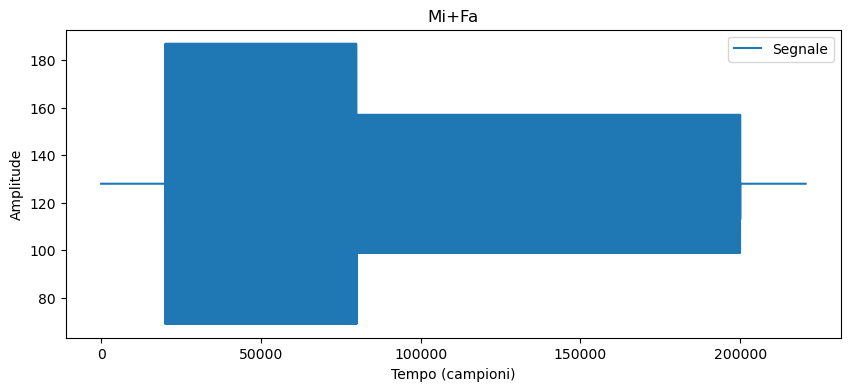

In [10]:
mi = note(30, 60, "E", 3, 10)
fa= note(60, 30, "F", 5, 40)
ind = individual (5, 44100, {mi, fa}, 2000)
plot_signal(ind.get_signal(), 'Mi+Fa')
save_wave_file('mi+fa.wav', ind.get_signal(), 44100)


##### Single note mutation

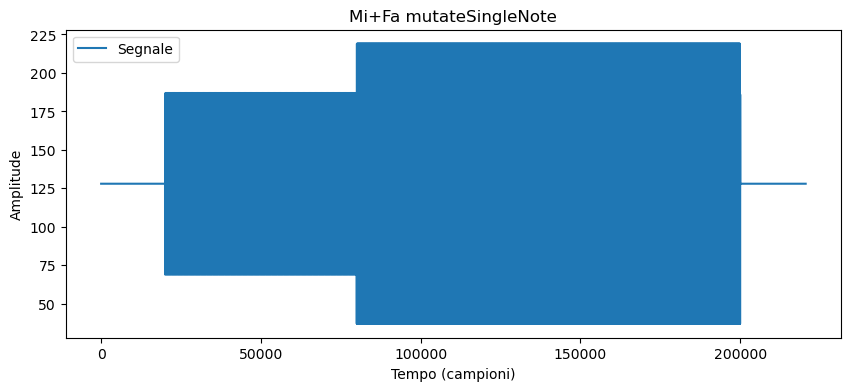

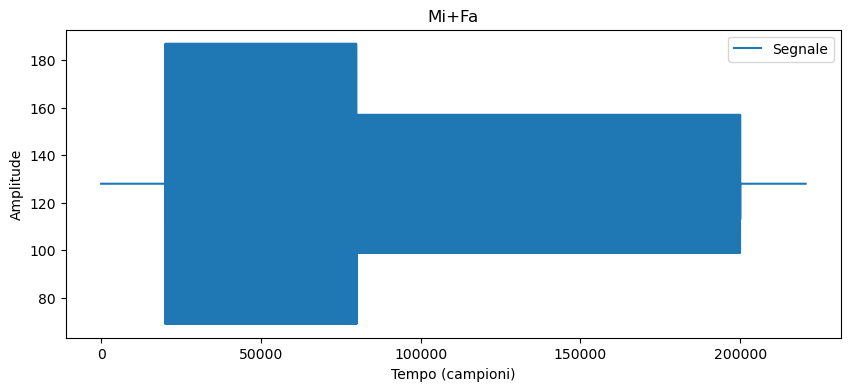

New notes:
duration: 30 intensity: 60 name: E octave: 3 starting point: 10
duration: 60 intensity: 92 name: A# octave: 4 starting point: 40


In [12]:
ind2= ind.single_note_mutation()
plot_signal(ind2.get_signal(), 'Mi+Fa mutateSingleNote')
plot_signal(ind.get_signal(), 'Mi+Fa')


print("New notes:")
for y in ind2.get_notes():
    print('duration:', y.duration_in_64ths, 'intensity:', y.intensity, 'name:', y.name, 'octave:', y.octave, 'starting point:', y.starting_point_in_64ths)

##### Split note mutation

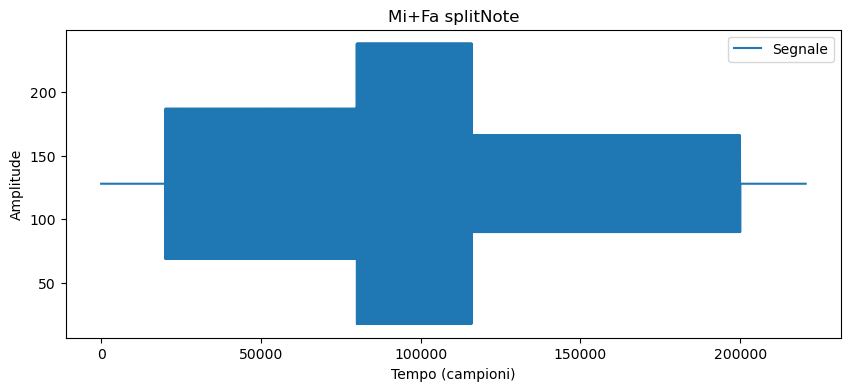

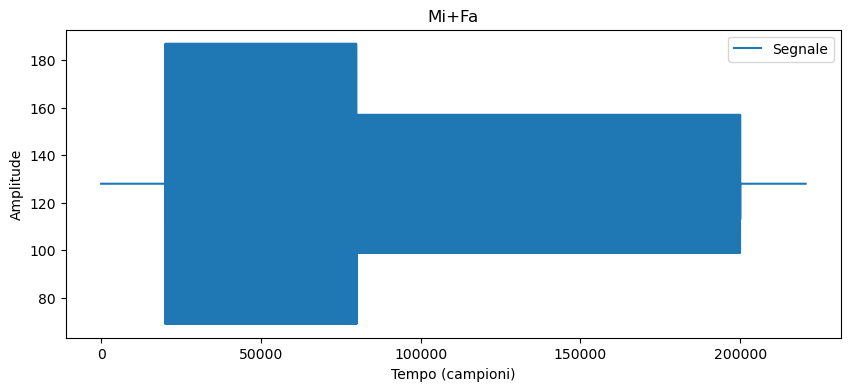

New Notes:
duration: 30 intensity: 60 name: E octave: 3 starting point: 10
duration: 18 intensity: 111 name: A octave: 4 starting point: 40
duration: 42 intensity: 39 name: D octave: 4 starting point: 58


In [13]:
ind3= ind.split_note_mutation()
plot_signal(ind3.get_signal(), 'Mi+Fa splitNote')
plot_signal(ind.get_signal(), 'Mi+Fa')

print("New Notes:")
for y in ind3.get_notes():
    print('duration:', y.duration_in_64ths, 'intensity:', y.intensity, 'name:', y.name, 'octave:', y.octave, 'starting point:', y.starting_point_in_64ths)

##### Merge two notes mutation

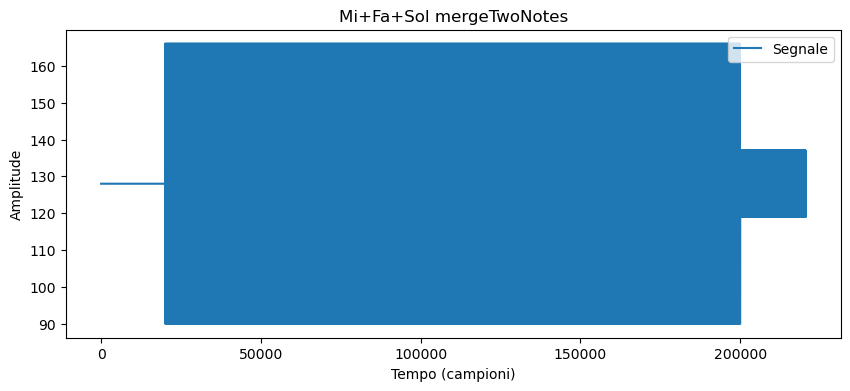

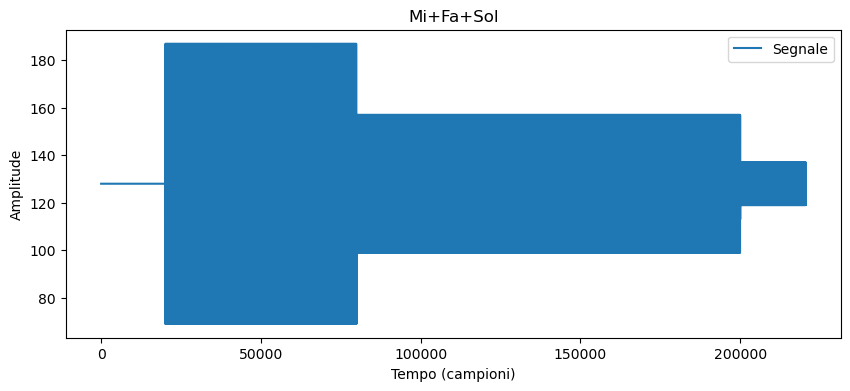

old notes
duration: 30 intensity: 60 name: E octave: 3 starting point: 10
duration: 60 intensity: 30 name: F octave: 5 starting point: 40
duration: 40 intensity: 10 name: G octave: 5 starting point: 100
new notes
duration: 90 intensity: 39 name: D# octave: 4 starting point: 10
duration: 40 intensity: 10 name: G octave: 5 starting point: 100


In [14]:
sol= note(40, 10, "G", 5, 100)
ind4 = individual (5, 44100, {mi, fa, sol}, 2000)

ind5= ind4.merge_two_notes_mutation()
plot_signal(ind5.get_signal(), 'Mi+Fa+Sol mergeTwoNotes')
plot_signal(ind4.get_signal(), 'Mi+Fa+Sol')

print("old notes")
for x in ind4.get_notes():
    print('duration:', x.duration_in_64ths, 'intensity:', x.intensity, 'name:', x.name, 'octave:', x.octave, 'starting point:', x.starting_point_in_64ths)

print("new notes")
for y in ind5.get_notes():
    print('duration:', y.duration_in_64ths, 'intensity:', y.intensity, 'name:', y.name, 'octave:', y.octave, 'starting point:', y.starting_point_in_64ths)

### Song

Class to create a song object from a .wav file. The song will be the target of an evolution

In [15]:

class song:

    def __init__(self, filename):
        with wave.open(filename, 'r') as wave_file:
            nframes=wave_file.getnframes()
            nbyte= wave_file.getsampwidth()
            nbits=8*nbyte
            dtype_name = f'uint{nbits}'
            dtype = getattr(np, dtype_name)
            nchannels = wave_file.getnchannels()
            signal= np.frombuffer(wave_file.readframes(nframes*nchannels), dtype=dtype)
            signal = signal.reshape((nframes, nchannels))
            self.__signal=signal[:, 0]
            self.__nbyte = nbyte
            self.__sample_rate = wave_file.getframerate()
            self.__duration = nframes/self.__sample_rate
            

    def get_signal(self):
        return self.__signal
    
    def get_duration(self):
        return self.__duration
    
    def get_num_bytes(self):
        return self.__nbyte
    
    def get_sample_rate(self):
        return self.__sample_rate


### Fitness functions

#### Measurement of the similarity of a candidate to a song using Pearson correlation

In [16]:
def pearson_correlation (song, candidate):
    to_compare = candidate.get_signal().copy()
    to_compare *= song.get_num_bytes()
    candidate_freq = candidate.get_sample_rate() 
    duration = candidate.get_duration()  
    candidate_time = np.arange(0, duration, 1/candidate_freq) 
    song_freq = song.get_sample_rate()
    song_time = np.arange(0, duration, 1/song_freq)
    interpolator = interp1d(candidate_time, to_compare, kind='linear', fill_value='extrapolate')
    interpolated = interpolator(song_time)
    to_compare= interpolated
    signal= song.get_signal()    
    return np.corrcoef(signal, to_compare)[0, 1]


#### Measurement of the similarity of a candidate to a song using Pearson correlation on the Fourier coefficients

In [17]:
def pearson_correlation_frequency_domain (song, candidate):
    to_compare = candidate.get_signal().copy()
    to_compare *= song.get_num_bytes()
    candidate_freq = candidate.get_sample_rate() 
    duration = candidate.get_duration()  
    candidate_time = np.arange(0, duration, 1/candidate_freq) 
    song_freq = song.get_sample_rate()
    song_time = np.arange(0, duration, 1/song_freq)
    interpolator = interp1d(candidate_time, to_compare, kind='linear', fill_value='extrapolate')
    interpolated = interpolator(song_time)
    to_compare= interpolated
    signal= song.get_signal() 
    songFd= np.abs(fft(signal))
    candidateFd= np.abs(fft(to_compare))
    return np.corrcoef(songFd, candidateFd)[0, 1]

#### Measurement of the similarity of a candidate to a song using Pearson correlation on the Wavelet coefficients

In [18]:
def correlation_wavelet_coefficients(song, candidate):
    to_compare = candidate.get_signal().copy()
    to_compare *= song.get_num_bytes()
    candidate_freq = candidate.get_sample_rate() 
    duration = candidate.get_duration()  
    candidate_time = np.arange(0, duration, 1/candidate_freq) 
    song_freq = song.get_sample_rate()
    song_time = np.arange(0, duration, 1/song_freq)
    interpolator = interp1d(candidate_time, to_compare, kind='linear', fill_value='extrapolate')
    interpolated = interpolator(song_time)
    to_compare= interpolated
    signal= song.get_signal() 
    songWl = pywt.wavedec(signal, 'db1', level=5)
    candidateWl = pywt.wavedec(to_compare, 'db1', level=5)
    correlation_coeff = []
    for coeff1, coeff2 in zip(songWl, candidateWl):
        correlation_coeff.append(np.corrcoef(coeff1, coeff2)[0, 1])
    return np.mean(correlation_coeff)

#### Measurement of the similarity of a candidate to a song using mean squared error

In [19]:
def inverse_mean_squared_error(song, candidate):
    to_compare = candidate.get_signal().copy()
    to_compare *= song.get_num_bytes()
    candidate_freq = candidate.get_sample_rate() 
    duration = candidate.get_duration()  
    candidate_time = np.arange(0, duration, 1/candidate_freq) 
    song_freq = song.get_sample_rate()
    song_time = np.arange(0, duration, 1/song_freq)
    interpolator = interp1d(candidate_time, to_compare, kind='linear', fill_value='extrapolate')
    interpolated = interpolator(song_time)
    to_compare= interpolated
    signal= song.get_signal() 
    return 1/(np.mean((signal - to_compare) ** 2)+1)

#### Test

In [20]:
song0 = song('caffe.wav')
candidate = individual(song0.get_duration(), 44100, {mi}, 2000)

In [21]:
print (pearson_correlation(song0, candidate))

0.012994187849195439


In [22]:
print (pearson_correlation_frequency_domain(song0, candidate))

0.41213044180828057


In [23]:
print (correlation_wavelet_coefficients(song0, candidate))

0.0028031557085623736


In [24]:
print(inverse_mean_squared_error(song0, candidate))

4.916236522121552e-10


### Initialization of the population

#### Method to generate random individual

In [25]:
def generate_random_individual(duration, sample_rate, duration_of_64th_in_samples):
    notes_array =[]
    num_of_64ths= int(duration*sample_rate/duration_of_64th_in_samples)
    next_note_beginning_in_64ths=0
    while (next_note_beginning_in_64ths<num_of_64ths):
        note_duration= np.random.randint(min(32, num_of_64ths-next_note_beginning_in_64ths), min(65,1+num_of_64ths-next_note_beginning_in_64ths))
        notes_array.append(note(note_duration, np.random.randint(60,127), np.random.choice(note.NAMES), np.random.randint(4,6), next_note_beginning_in_64ths))
        next_note_beginning_in_64ths+=note_duration    
    i= individual(duration, sample_rate, notes_array, duration_of_64th_in_samples)
    return i

##### Test

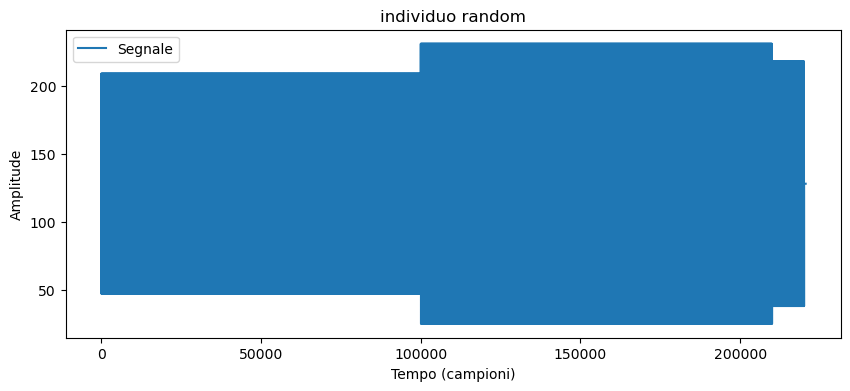

duration: 50 intensity: 82 name: D# octave: 4 starting point: 0
duration: 55 intensity: 104 name: F octave: 4 starting point: 50
duration: 5 intensity: 91 name: G# octave: 4 starting point: 105


In [26]:
i = generate_random_individual(5, 44100, 2000)
plot_signal(i.get_signal(), "individuo random")
save_wave_file("randomIndividual.wav", i.get_signal(), 44100)
for n in i.get_notes():
    print('duration:', n.duration_in_64ths, 'intensity:', n.intensity, 'name:', n.name, 'octave:', n.octave, 'starting point:', n.starting_point_in_64ths)

##### Test two point crossover with randomly generated individuals

In [28]:
j= generate_random_individual(5, 44100, 2000)
print("Notes of second parent")
for n in j.get_notes():
    print('duration:', n.duration_in_64ths, 'intensity:', n.intensity, 'name:', n.name, 'octave:', n.octave, 'starting point:', n.starting_point_in_64ths)
l, m = individual.two_points_crossover(i,j)
print("Notes of first offspring")
for n in l.get_notes():
    print('duration:', n.duration_in_64ths, 'intensity:', n.intensity, 'name:', n.name, 'octave:', n.octave, 'starting point:', n.starting_point_in_64ths)

Notes of second parent
duration: 39 intensity: 114 name: A# octave: 4 starting point: 0
duration: 37 intensity: 70 name: A octave: 4 starting point: 39
duration: 34 intensity: 89 name: A# octave: 4 starting point: 76
Notes of first offspring
duration: 39 intensity: 114 name: A# octave: 4 starting point: 0
duration: 37 intensity: 70 name: A octave: 4 starting point: 39
duration: 29 intensity: 89 name: A# octave: 4 starting point: 76
duration: 5 intensity: 91 name: G# octave: 4 starting point: 105


#### Method to initialize population

In [29]:
def init_population(pop_size, duration, sample_rate, duration_of_64ths_in_samples):
  return list([generate_random_individual(duration, sample_rate, duration_of_64ths_in_samples) for _ in range(0, pop_size)])

### Selection

#### Tournament selection method

In [30]:
def tournament_selection(pop, fit, k):
  tournament=[]
  copy= (list(pop)).copy()
  for _ in range(k):
    tournament.append(np.random.choice(copy))
  selected= sorted(tournament, key=fit, reverse=True)[0]
  return selected

#### Method to get the best individual in the population

In [31]:
def get_best(pop, fit):
  best=sorted(list(pop), key= fit, reverse=True)[0]
  return np.array([fit(best), best])

### Genetic algorithm

#### Generation method

The crossover is followed by a randomly chosen mutation method

In [32]:
def generation(pop, fit, t_size, n_offs):
  offsprings=[]
  while (len(offsprings)<n_offs):
    p1 = tournament_selection(pop, fit, t_size)
    p2 = tournament_selection(pop, fit, t_size)
    o1, o2 = individual.two_points_crossover(p1,p2)
    
    r= np.random.random()
    if(r<1/4):
      o1= o1.single_note_mutation()
      o2= o2.single_note_mutation()
    elif(1/4<=r<1/2):
      o1= o1.split_note_mutation()
      o2= o2.split_note_mutation()
    else:
      o1= o1.merge_two_notes_mutation()
      o2= o2.merge_two_notes_mutation()
  
    offsprings.append(o1)
    offsprings.append(o2)
  
  offsprings=offsprings[:n_offs]
  return offsprings

  

#### Genetic algorithm

Parameters:
- size of the population
- target song
- wether or not to use elitism (conserve the best individual found in the next generation)
- sample rate of the individuals
- duration in terms of samples of the semibisquavers (this parameter can be used to indicate how "fast" notes can be)
- fitness function
- tournament size
- number of generations

In [33]:
def GA(pop_size, target_song, elitism=False, sample_rate=44100, duration_of_64th_in_samples= 1000, sound_similarity_measure = pearson_correlation, t_size = 5, n_gen = 10):
  pop = init_population(pop_size, target_song.get_duration(), sample_rate, duration_of_64th_in_samples)
  def f(ind):
    return sound_similarity_measure(target_song, ind)
  best= get_best(pop,f)[1]
  print(type(pop))
  for i in range(0, n_gen):
    print("generation", i)
    if (elitism):
      offs = generation(pop, f, t_size, pop_size)
      new_best = sorted(offs, key=f, reverse=True)[0]
      if f(new_best)>f(best):
        best= new_best
        pop= offs
      else:
        pop=sorted(offs, key=f, reverse=True)[:pop_size]
        pop.append(best)
    else:
      pop = generation(pop, f, t_size, pop_size)
  return get_best(pop, f)

#### Computation and representation of a solution

<class 'list'>
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
fitness= 0.08471687885975546


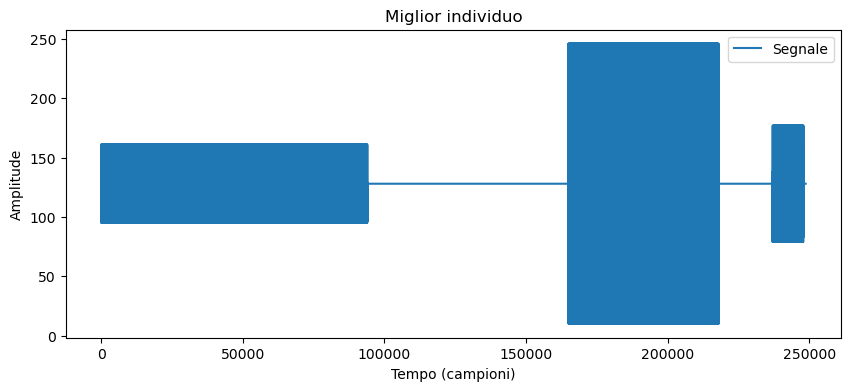

Notes
duration: 94 intensity: 34 name: B octave: 4 starting point: 0
duration: 71 intensity: 1 name: D octave: 4 starting point: 94
duration: 53 intensity: 119 name: D# octave: 5 starting point: 165
duration: 19 intensity: 1 name: C# octave: 4 starting point: 218
duration: 11 intensity: 50 name: E octave: 4 starting point: 237


In [34]:
s= GA(10, song("GBE.wav"))
print("fitness=", s[0])
solution= s[1]
plot_signal(solution.get_signal(), "Miglior individuo")
save_wave_file("best.wav", solution.get_signal(), 44100)
print("Notes")
for n in solution.get_notes():
    print('duration:', n.duration_in_64ths, 'intensity:', n.intensity, 'name:', n.name, 'octave:', n.octave, 'starting point:', n.starting_point_in_64ths)

### Possible improvements

- exploit possible a priori knowledge of the song
- parallelize to improve performances
- implement the possibility of more than one note to be played at the same time (for example introducing triads and chords)
- implement hybrid GA 